# Gesture Recognition Using LSTM

This notebook loads a sequence-based gesture dataset, preprocesses it, builds a Bidirectional LSTM model using Keras, and evaluates its performance. It also supports detailed exploratory data analysis (EDA) and exports model artifacts.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


## Parameters

In [2]:
DATA_DIR = "dataset"
SEQUENCE_LENGTH = 30
FEATURE_DIM = 126
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 50

## Load the dataset

Load `.npy` files from each class folder, ensure sequences are of fixed length by padding or truncating.


In [3]:
labels = []
sequences = []

for gesture in os.listdir(DATA_DIR):
    gesture_dir = os.path.join(DATA_DIR, gesture)
    if not os.path.isdir(gesture_dir):
        continue
    for fname in os.listdir(gesture_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(gesture_dir, fname)
        seq = np.load(path)
        if seq.shape[0] != SEQUENCE_LENGTH:
            if seq.shape[0] > SEQUENCE_LENGTH:
                seq = seq[:SEQUENCE_LENGTH]
            else:
                pad_width = SEQUENCE_LENGTH - seq.shape[0]
                seq = np.vstack([seq, np.zeros((pad_width, FEATURE_DIM))])
        sequences.append(seq)
        labels.append(gesture)

X = np.array(sequences)
y = np.array(labels)

print(f"Loaded {len(X)} samples from {len(np.unique(y))} classes.")

Loaded 609 samples from 5 classes.


# Exploratory Data analysis
## Class distribution


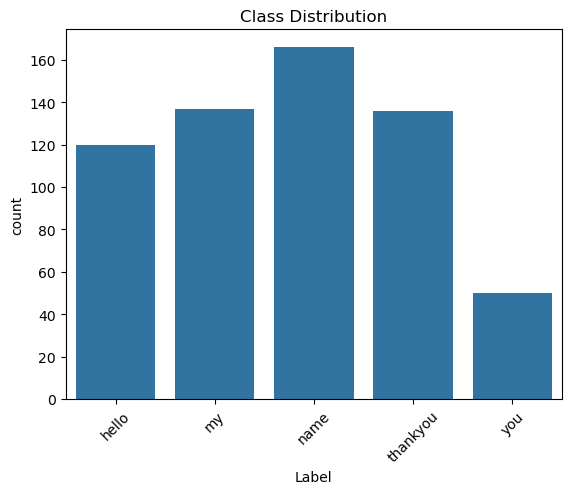

In [4]:
df = pd.DataFrame({'Label': y})
sns.countplot(data=df, x='Label')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Encode labels

In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split Dataset

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_cat)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE/(1 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 425, Val: 92, Test: 92


# Build model

In [7]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\renal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,189 (801.52 KB)

 Trainable params: 205,189 (801.52 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [8]:
checkpoint_path = 'artifacts/best_gesture_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3757 - loss: 1.4120

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3808 - loss: 1.4005 - val_accuracy: 0.5870 - val_loss: 0.9092
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5838 - loss: 0.9266

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5857 - loss: 0.9240 - val_accuracy: 0.6848 - val_loss: 0.6247
Epoch 3/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7563 - loss: 0.6679

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7604 - loss: 0.6587 - val_accuracy: 0.9022 - val_loss: 0.3348
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9042 - loss: 0.3508 - val_accuracy: 0.8696 - val_loss: 0.4137
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8680 - loss: 0.4030 - val_accuracy: 0.7826 - val_loss: 0.5146
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8480 - loss: 0.3896

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8487 - loss: 0.3892 - val_accuracy: 0.9348 - val_loss: 0.2514
Epoch 7/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9544 - loss: 0.2167

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9541 - loss: 0.2152 - val_accuracy: 0.9457 - val_loss: 0.1942
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9770 - loss: 0.1201 - val_accuracy: 0.9457 - val_loss: 0.2233
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9687 - loss: 0.1243 - val_accuracy: 0.9565 - val_loss: 0.1943
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9775 - loss: 0.1064 - val_accuracy: 0.8913 - val_loss: 0.3543
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9405 - loss: 0.2084

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9410 - loss: 0.2072 - val_accuracy: 0.9565 - val_loss: 0.1930
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9356 - loss: 0.2387 - val_accuracy: 0.9239 - val_loss: 0.1988
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9411 - loss: 0.2315

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9409 - loss: 0.2316 - val_accuracy: 0.9348 - val_loss: 0.1833
Epoch 14/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9395 - loss: 0.1811

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9404 - loss: 0.1792 - val_accuracy: 0.9565 - val_loss: 0.1679
Epoch 15/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9887 - loss: 0.0738

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9885 - loss: 0.0741 - val_accuracy: 0.9783 - val_loss: 0.1237
Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9871 - loss: 0.0533 - val_accuracy: 0.9783 - val_loss: 0.1455
Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9884 - loss: 0.0633 - val_accuracy: 0.9783 - val_loss: 0.1494
Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9902 - loss: 0.0407

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9901 - loss: 0.0412 - val_accuracy: 0.9783 - val_loss: 0.0913
Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9620 - loss: 0.1535 - val_accuracy: 0.7500 - val_loss: 0.5069
Epoch 20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9486 - loss: 0.2095

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9491 - loss: 0.2076 - val_accuracy: 0.9783 - val_loss: 0.0812
Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9685 - loss: 0.1024 - val_accuracy: 0.9783 - val_loss: 0.1042
Epoch 22/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9902 - loss: 0.0581 - val_accuracy: 0.9674 - val_loss: 0.1368
Epoch 23/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9856 - loss: 0.0444 - val_accuracy: 0.9457 - val_loss: 0.2735
Epoch 24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9516 - loss: 0.1952 - val_accuracy: 0.9565 - val_loss: 0.1439
Epoch 25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9777 - loss: 0.0937 - val_accuracy: 0.9457 - val_loss: 0.1930
Epoch 26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9721 - loss: 0.1162 - val_accuracy: 0.9457 - val_loss: 0.1633
Epoch 27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9882 - loss: 0.0426

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9880 - loss: 0.0430 - val_accuracy: 0.9891 - val_loss: 0.0445
Epoch 28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9965 - loss: 0.0274 - val_accuracy: 0.9348 - val_loss: 0.1555
Epoch 29/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9791 - loss: 0.0483 - val_accuracy: 0.9565 - val_loss: 0.0888
Epoch 30/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9927 - loss: 0.0222 - val_accuracy: 0.9674 - val_loss: 0.1197
Epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9846 - loss: 0.0545 - val_accuracy: 0.9674 - val_loss: 0.1380
Epoch 32/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9918 - loss: 0.0258 - val_accuracy: 0.9457 - val_loss: 0.3115
Epoch 33/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9802 - loss: 0.0459 - val_accuracy: 0.9783 - val_loss: 0.0837
Epoch 34/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9947 - loss: 0.0291 - val_accuracy: 0.9565 - val_l

# Plot training history

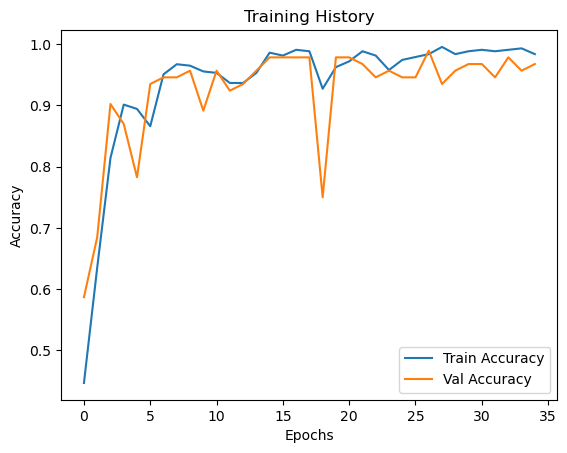

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()


# Evaluate and Analyze Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0039
Test Accuracy: 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step

Classification Report:
              precision    recall  f1-score   support

       hello       1.00      1.00      1.00        18
          my       1.00      1.00      1.00        21
        name       1.00      1.00      1.00        25
    thankyou       1.00      1.00      1.00        20
         you       1.00      1.00      1.00         8

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92



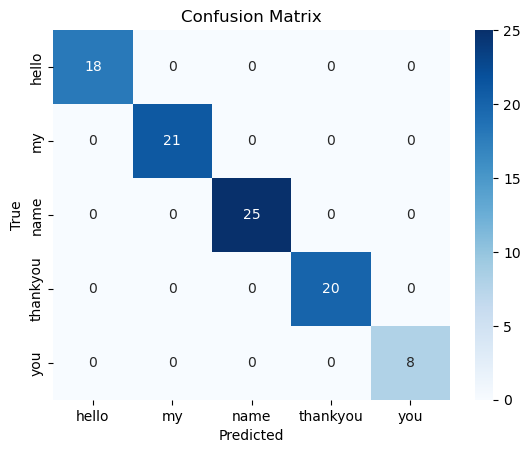

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Save Artifacts

In [11]:
with open('artifacts/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved.")


Model and label encoder saved.
